In [1]:
import numpy as np
import pandas as pds
from copy import deepcopy
from random import shuffle

"""
    Different correlations
"""
from scipy.linalg import eigh, cholesky
from scipy.stats import norm, pearsonr

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, './')
from Pareto import *

matplotlib.rcParams['font.family'] = "Sans-serif"
matplotlib.rcParams['font.serif'] = "Arial" # Helvetica
matplotlib.rcParams['font.style'] = "normal"
matplotlib.rcParams['font.weight'] = 'light'
matplotlib.rcParams['mathtext.fontset'] = "custom"
matplotlib.rcParams['mathtext.rm'] = "Arial"

# Analyzing the Pareto fronts of correlated random variables
 - Why this section is needed and important?  
   &emsp; This analysis provides a background and a theoretical verification of the trade-off effects for optimal models on the Pareto fronts. The algorithms to compute Pareto fronts will always generate a set of optimal points which are negatively correlated on Pareto fronts. While having a negative correlation is often interpreted as a trade-off, this interpretation will obviously be problematic and will be inconsistent with the fact when the overall data (<u>NOT ONLY</u> the optimal data points on Pareto fronts) have strong and positive correlations. As is demonstrated in the last figure below which has two correlated random variables, *X1* and *X2*, with $r$ = 0.8, the optimal data on the Pareto front (black thin line) are still negatively correlated, **contradicting** with the correlations of overall trend. In this case, the trade-off effect of negatively correlated optimal data will be a misinterpretation.  
   &emsp; Since optimal data that are negatively correlated on the Pareto fronts may not always reflect the correlation of overall variables, we need to verify the trade-off effect of optimal data to ensure that the overall variables are weakly correlated, uncorrelated, or negatively correlated. This can be done by calculating the distribution of number of optimal points $N_{\mathrm{optimal}}$ and counting the median $N_{\mathrm{optimal}}$, as is shown in this section.  
   
 - How to verify that the overall variables are at least weakly correlated?  
   &emsp; For the correlated random variables, the $N_{\mathrm{optimal}}$ is generally lower if the correlations are higher, as shown in `N-optimal_random_variables.png` in `data/` directory. Specifically, for random variables that are strongly correlated, like $r$ > 0.8, the median $N_{\mathrm{optimal}}$ will approximate the number of dimensions $D$, or lower. The median $N_{\mathrm{optimal}}$ in 4$D$ or 5$D$ space for $r$ = 0.01 and 0.3 (median $N_{\mathrm{optimal}}$ = 101 and 45 in 4$D$ respectively, and median $N_{\mathrm{optimal}}$ = 220 and 81 in 5$D$) will be good benchmarks of having weak correlations or no correlation. In comparison, our dataset $\mathcal{D}_{\mathrm{2300}}^{\mathrm{48}D}$ has median $N_{\mathrm{optimal}}$ at 75 and 137 in 4$D$ and 5$D$, which are between the values provided by random variables with $r$ = 0.01 and 0.3, approaching the values of $r$ = 0.01. This proves that the properties in our dataset are generally weakly correlated at least. Therefore, the trade-off effects of optimal models on the Pareto fronts for different properties are valid results.  

In [3]:
## Choice of cholesky or eigenvector method.
method = 'cholesky'
## method = 'eigenvectors'

num_samples = 2300 ## similar to the number of MLIP models
dim = 50 ## similar to the number of properties

### Generating correlated random variables using Cholesky method

Here we use the Cholesky method to generate a dataset of correlated random variables. This method is implemented here: [Scipy Cookbook](https://scipy-cookbook.readthedocs.io/items/CorrelatedRandomSamples.html#:~:text=To%20generate%20correlated%20normally%20distributed,eigenvalues%20and%20eigenvectors%20of%20R).  
1. We first generate a dataset of random variables (all variables are standardized, $<v>$=0 and $\sigma_{\mathrm{v}}$=1). The size of the dataset will be 2300 * 50, approximately the same size of our $\mathcal{D}_{\mathrm{2300}}^{\mathrm{48}D}$.  
2. We then use a covariance matrix and the Cholesky decomposition to convert the initial independent random variables to correlated random variables.  
3. After that, we randomly select 250 Pareto fronts in fixed multi-dimensional space of $D$ = 2, 3, 4, and 5. Each Pareto front for a certain dimension $D$ will be constructed by randomly selecting $D$ variables so that the Pareto fronts will have different $N_{\mathrm{optimal}}$.  
4. Finally, we plot the distributions of $N_{\mathrm{optimal}}$ for different $D$ and count their median $N_{\mathrm{optimal}}$.  
   
**Note**: the method currently can only be applied on positive correlations. If the target correlation is negative, we need other algorithms.

In [4]:
corr = 0.3 ## target correlation

"""
    Step 1
"""
## Generate samples from three independent normally distributed random
## variables (with mean 0 and std. dev. 1).
## Here, variables are uncorrelated.
x = norm.rvs(size=(dim, num_samples))

"""
    Step 2
"""
## The desired covariance matrix.
## All diagonal terms are 1 and non-diagonal terms are target correlation
## coefficients (Pearson's r). This is suitable because we intend to 
## generate standardized random variables.

## Note that if the variables are not standardized, this step should be
## modified.
r = []
for ix in range(dim):
    tmp = []
    for iy in range(dim):
        if iy==ix:
            tmp.append(1)
        else:
            tmp.append(corr)
    r.append(deepcopy(tmp))
r = np.array(r)

## We need a matrix `c` for which `c*c^T = r`.  We can use, for example,
## the Cholesky decomposition, or the we can construct `c` from the
## eigenvectors and eigenvalues.
if method == 'cholesky':
    ## Compute the Cholesky decomposition.
    c = cholesky(r, lower=True)
else:
    ## Compute the eigenvalues and eigenvectors.
    evals, evecs = eigh(r)
    ## Construct c, so c*c^T = r.
    c = np.dot(evecs, np.diag(np.sqrt(evals)))

## Convert the data to correlated random variables. 
y = np.dot(c, x)

In [5]:
indices = [n for n in range(dim)]
attempts = 250
results = {'N_D': [], 'N_optimal': []}

## Iterate over 2 - 5 dimensions
for ndim in range(2, 6):
    """
        Step 3
    """
    ## Randomly generate 250 Pareto fronts in N_D dimension
    ## Study the N_optimal distribution with these Pareto fronts
    for a in range(attempts):
        ## Randomly select N_D variables (fix N_D),
        ## so that N_optimal will be different every time
        shuffle(indices)

        ## N_D * 2300 matrix
        data = [deepcopy(y[index]) for index in indices[:ndim]]
        ## 2300 * N_D matrix
        ## This is used to find the Pareto fronts.
        t_data = np.transpose(data)
        output = is_pareto_efficient(deepcopy(t_data))
        results['N_D'].append(ndim)
        results['N_optimal'].append(len([n for n in output if n]))
rdf = pds.DataFrame(results)

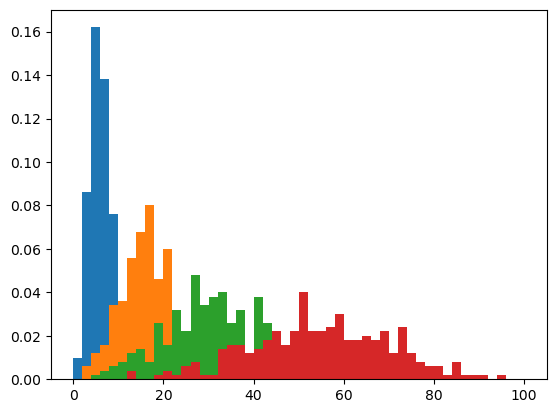

In [6]:
"""
    Post-process: get the distribution (probability density functions, PDFs)
"""
xs = np.linspace(0, 100, 51)
dx = xs[1]-xs[0]
y_sum = []
p_sum = []

for ndim in range(2, 6):
    tmpdf = rdf.loc[rdf['N_D']==ndim]
    p = [n for n in tmpdf['N_optimal']]
    ty, tx, _ = plt.hist(p, bins=xs, density=True)
    y_sum.append(deepcopy(ty))
    p_sum.append(np.median(p))

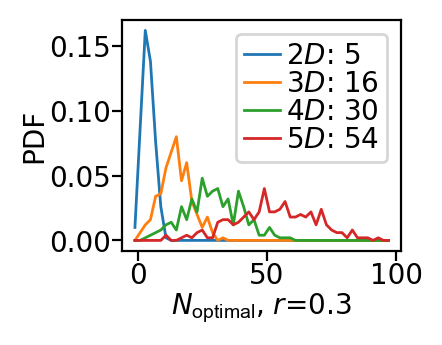

In [7]:
"""
    Step 4: show the distributions
"""
fig = plt.figure(figsize=(1.8, 1.5), dpi=200)
ax = plt.subplot(1, 1, 1)

for iy, (ty, tp) in enumerate(zip(y_sum, p_sum)):
    ax.plot([n-dx/2 for n in xs[:-1]], ty, linewidth=1,
            label='{}$D$: {}'.format(iy+2, int(np.median(tp))))
## Figure format
ax.set_xlabel('$N_{\mathrm{optimal}}$, '+'$r$={}'.format(round(corr, 2)), fontsize=10, labelpad=0.5)
ax.set_ylabel('PDF', fontsize=10, labelpad=0.5)
plt.tick_params(axis='both', which='major', labelsize=10, pad=0.5)
lgd = plt.legend(loc='best', fontsize=10, ncol=1, columnspacing=0.4, handlelength=1.3,
                 borderpad=0.3, labelspacing=0, handletextpad=0.2)

plt.show()
plt.clf()
plt.close()

In [8]:
## Randomly select two variables
## Verify the correlations
v1_index = 0
v2_index = 11
shuffle(indices)
var1 = y[indices[v1_index]]
var2 = y[indices[v2_index]]

r, _ = pearsonr(var1, var2)
print('r:', round(r, 2), '; r2:', round(r**2, 2))

vardata = [(m, n) for m, n in zip(var1, var2)]
var_out = is_pareto_efficient(np.array(vardata))
pareto_data = [m for m, n in zip(vardata, var_out) if n]
pareto_data = sorted(pareto_data, key=lambda k: k[0])
px = [n[0] for n in pareto_data]
py = [n[1] for n in pareto_data]

r: 0.8 ; r2: 0.64


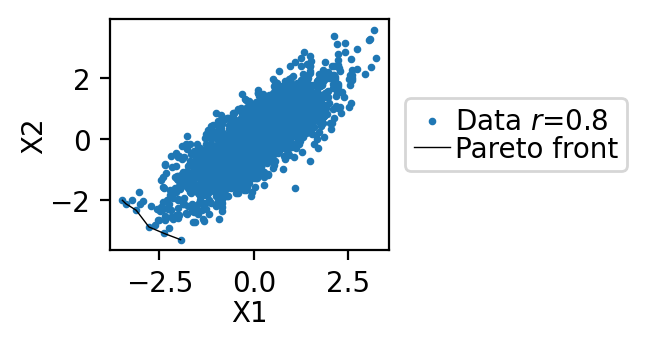

In [9]:
fig = plt.figure(figsize=(1.8, 1.5), dpi=200)
ax = plt.subplot(1, 1, 1)

ax.scatter(y[indices[v1_index]], y[indices[v2_index]], s=3, label=r'Data $r$={}'.format(round(corr, 2)))
ax.plot(px, py, linewidth=0.5, color='black', label='Pareto front')

ax.set_xlabel('X1', fontsize=10, labelpad=0.5)
ax.set_ylabel('X2', fontsize=10, labelpad=0.5)
lgd = plt.legend(bbox_to_anchor=(1.01, 0.5), loc='center left', fontsize=10, ncol=1,
                 columnspacing=0.4, handlelength=1.3, borderpad=0.3, labelspacing=0,
                 handletextpad=0.2)
plt.show()
plt.clf()
plt.close()